<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/CVNL_P02_GP01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Imports
import os
import torch
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Download dataset from KaggleHub
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

#define paths to the training and testing data directories
data_dir = '/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train'
# no longer using the test_dir because there is only 1 image per class and there is simply not enough for evaluation
# test_dir = '/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_test/asl_alphabet_test'

# Check dataset files
print("Path to dataset:", data_dir)

Path to dataset: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train
Total images: 87000
Training images: 60899
Validation images: 26101


In [ ]:
#zhi heng
#Define helper function to calculate mean and std
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

#zhi heng
#Calculate dataset-specific mean and std
raw_transform = transforms.Compose([
    transforms.ToTensor()
])
raw_dataset = datasets.ImageFolder(root=data_dir, transform=raw_transform)
mean, std = calculate_mean_std(raw_dataset)
print(f"Dataset Mean: {mean}, Std: {std}")

In [ ]:
mean = mean
std = std

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop(128, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load full dataset (folders act as labels)
full_dataset = datasets.ImageFolder(root=data_dir)

# Define train-validation split
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transforms after the split (to avoid validation augmentation)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Print dataset summary
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

In [14]:
#model cnn model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
'''
typical architecture of a CNN
1. input
2. conv
3. relu
4. pooling
5. fully connected layers
5. output pred

considerations:
how many conv layers do i need for feature extraction?
how many hidden layers?
how many channels?
'''

class CNN(nn.Module):
    def __init__(self, num_classes=29):
        super(CNN, self).__init__()

        self.model = nn.Sequential(
            # conv1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # conv2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # conv3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),  # Correct input size
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.model(x)
        #print(x.shape)
        x = self.fc(x)
        return x

In [15]:
def train(model, train_loader, loss_func, optimizer, device, epochs):
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        # Initialize tqdm progress bar for the current epoch
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True,
                             bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}", colour='green')

        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update epoch loss and accuracy
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update the progress bar with current metrics
            progress_bar.set_postfix({
                "Loss": f"{epoch_loss / (batch_idx + 1):.4f}",  # Average loss so far
                "Acc": f"{100. * correct / total:.2f}%"        # Current accuracy
            })

        # Print epoch summary
        print(f"Epoch {epoch+1}: Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {100. * correct / total:.2f}%")

In [16]:
def test(model, test_loader, loss_func, device):
    model.eval()  #set model to eval mode
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=True,
                             bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}", colour='green')

        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            progress_bar.set_postfix({
                "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                "Accuracy": f"{100. * correct / total:.2f}%"
            })

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return avg_test_loss, test_accuracy, y_true, y_pred

In [17]:
# Define model, loss function, optimizer, etc.
#check if gpu available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print(device)

model = CNN(num_classes=29).to(device)
loss_func = nn.CrossEntropyLoss()
epochs = 10
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

# Call the train function
train(model, train_loader, loss_func, optimizer, device, epochs=epochs)
avg_test_loss, test_accuracy, y_true, y_pred = test(model, val_loader, loss_func, device)

cuda


Epoch 1/10: 100%|██████████| 952/952 [02:21<00:00,  6.74it/s, Loss=1.7622, Acc=46.70%]


Epoch 1: Loss: 1.7622, Accuracy: 46.70%


Epoch 2/10: 100%|██████████| 952/952 [02:21<00:00,  6.75it/s, Loss=0.6358, Acc=78.87%]


Epoch 2: Loss: 0.6358, Accuracy: 78.87%


Epoch 3/10: 100%|██████████| 952/952 [02:20<00:00,  6.76it/s, Loss=0.3632, Acc=87.72%]


Epoch 3: Loss: 0.3632, Accuracy: 87.72%


Epoch 4/10: 100%|██████████| 952/952 [02:20<00:00,  6.76it/s, Loss=0.2512, Acc=91.47%]


Epoch 4: Loss: 0.2512, Accuracy: 91.47%


Epoch 5/10: 100%|██████████| 952/952 [02:20<00:00,  6.78it/s, Loss=0.1908, Acc=93.56%]


Epoch 5: Loss: 0.1908, Accuracy: 93.56%


Epoch 6/10: 100%|██████████| 952/952 [02:20<00:00,  6.79it/s, Loss=0.1508, Acc=94.84%]


Epoch 6: Loss: 0.1508, Accuracy: 94.84%


Epoch 7/10: 100%|██████████| 952/952 [02:20<00:00,  6.79it/s, Loss=0.1236, Acc=95.76%]


Epoch 7: Loss: 0.1236, Accuracy: 95.76%


Epoch 8/10: 100%|██████████| 952/952 [02:19<00:00,  6.80it/s, Loss=0.1038, Acc=96.45%]


Epoch 8: Loss: 0.1038, Accuracy: 96.45%


Epoch 9/10: 100%|██████████| 952/952 [02:20<00:00,  6.78it/s, Loss=0.0884, Acc=97.02%]


Epoch 9: Loss: 0.0884, Accuracy: 97.02%


Epoch 10/10: 100%|██████████| 952/952 [02:21<00:00,  6.72it/s, Loss=0.0831, Acc=97.22%]


Epoch 10: Loss: 0.0831, Accuracy: 97.22%


Testing: 100%|██████████| 408/408 [00:51<00:00,  7.90it/s, Loss=0.0143, Accuracy=99.64%]

Test Loss: 0.0143, Test Accuracy: 99.64%


ValueError: too many values to unpack (expected 2)

Accuracy: 0.9964 Precision: 0.9964 Recall: 0.9964 F1-Score: 0.9964

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       894
           B       1.00      0.98      0.99       925
           C       1.00      1.00      1.00       917
           D       1.00      1.00      1.00       868
           E       0.99      1.00      0.99       912
           F       1.00      1.00      1.00       902
           G       1.00      0.99      0.99       895
           H       0.99      1.00      1.00       897
           I       1.00      1.00      1.00       904
           J       1.00      1.00      1.00       845
           K       1.00      0.99      1.00       887
           L       1.00      1.00      1.00       905
           M       1.00      1.00      1.00       901
           N       1.00      1.00      1.00       911
           O       1.00      1.00      1.00       895
           P       1.00      1.00      1.00 

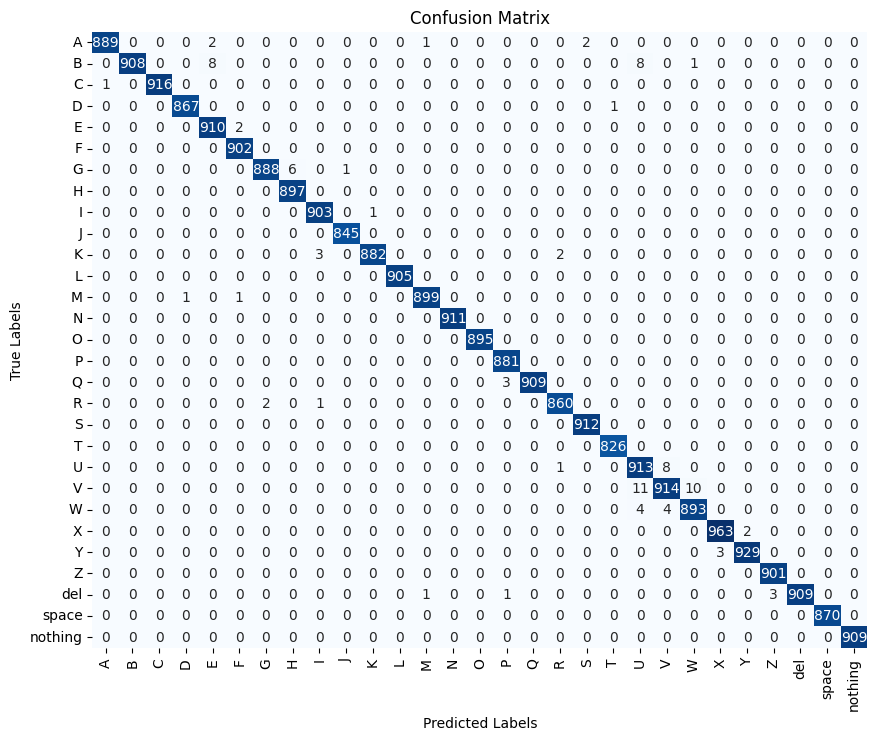

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are already defined
y_true = y_true  # List or array of true labels
y_pred = y_pred  # List or array of predicted labels

# Define class names (A-Z, 'del', 'space', 'nothing')
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space', 'nothing']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()